In [42]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm
from functools import reduce
from lr.text_processing.util import pre_process_nli_df, get_vocab_count
from lr.text_processing.transformations.util import get_augmented_data
from lr.training.util import get_binary_label, get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
from lr.stats.matched_comparison import get_disagreement_statistics
from lr.stats.bootstrap import get_bootstrap_replications, apply_transformation_under_H0
from IPython.display import HTML, display
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# load data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
df = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(df)
pre_process_nli_df(dev)

## Creating transformation that forces difference

In [3]:
def label_internalization(df):
    df_new = df.copy()
    df_new.loc[:,"hypothesis"] = df.hypothesis + " " + df.label
    return df_new

# transformation = label_internalization
transformation = entailment_internalization

display(HTML(transformation(df.head(4)).to_html()))

,premise,hypothesis,label
0,,a couple playing with a little boy on the beach implies that a couple are playing with a young child outside,entailment
1,,a man with a red shirt is watching another man who is standing on top of a attached cart filled to the top implies that the men are outside,neutral
2,,"a busy city that looks like new york city , the city looks like lawrence kansas",contradiction
3,,a blond woman with two children is checking out at a walmart register implies that a mother is with her two children at walmart buying food,neutral


## Applaying transformation to a part of the data

In [4]:
df_ = get_augmented_data(df=df.head(4),
                         transformation=transformation,
                         frac=0.5)

display(HTML(df_.to_html()))

,premise,hypothesis,label
0,a couple playing with a little boy on the beach,a couple are playing with a young child outside,entailment
1,,a man with a red shirt is watching another man who is standing on top of a attached cart filled to the top implies that the men are outside,neutral
2,a busy city that looks like new york city,the city looks like lawrence kansas,contradiction
3,,a blond woman with two children is checking out at a walmart register implies that a mother is with her two children at walmart buying food,neutral


### Check `apply_transformation_under_H0`

In [5]:
original_h0, transformed_h0 = apply_transformation_under_H0(df.head(4), df_transformation_f=transformation)

print("original under h0")

display(HTML(original_h0.to_html()))
print("transformed  under h0")
display(HTML(transformed_h0.to_html()))

original under h0


,premise,hypothesis,label
0,a couple playing with a little boy on the beach,a couple are playing with a young child outside,entailment
1,a man with a red shirt is watching another man who is standing on top of a attached cart filled to the top,the men are outside,neutral
2,,"a busy city that looks like new york city , the city looks like lawrence kansas",contradiction
3,,a blond woman with two children is checking out at a walmart register implies that a mother is with her two children at walmart buying food,neutral


transformed  under h0


,premise,hypothesis,label
0,,a couple playing with a little boy on the beach implies that a couple are playing with a young child outside,entailment
1,,a man with a red shirt is watching another man who is standing on top of a attached cart filled to the top implies that the men are outside,neutral
2,a busy city that looks like new york city,the city looks like lawrence kansas,contradiction
3,a blond woman with two children is checking out at a walmart register,a mother is with her two children at walmart buying food,neutral


## Bootstrap hypothesis testing

In [6]:
B = 1000
max_features = 500
pcts = [0.345]
label_translation = get_ternary_label

ids = [[i] * B for i in pcts]
ids = reduce(lambda x,y: x + y, ids)

boot_stats = []

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}

for pct in tqdm(ids):
    train_b = get_bootstrap_replications(df)
    dev_b = get_bootstrap_replications(dev)
    train_b_aug = get_augmented_data(df=train_b,
                                     transformation=transformation,
                                     frac=pct)
    dev_b_original, dev_b_t = apply_transformation_under_H0(dev_b, df_transformation_f=transformation)
    
    lr = LRWrapper(hyperparams)
    lr.fit(train_b_aug)

    st = get_disagreement_statistics(df=dev_b_original,
                                     df_t=dev_b_t,
                                     model=lr,
                                     label_translation=label_translation)


    boot_stats.append(st)
    del lr, train_b, dev_b
    

boot_result = pd.concat(boot_stats)
boot_result.index = ids
boot_result.index.name = "pcts"

100%|██████████| 1000/1000 [02:13<00:00,  7.45it/s]


### Bootstrap results

In [7]:
boot_result.head(3)

,acc,acct,acc_minus_acct,t1,C,D,E,F,t2,pos_trans_rate,neg_trans_rate
pcts,,,,,,,,,,,
0.345,0.300,0.330,-0.03,-0.973200,44,16,22,118,0.947368,0.578947,0.421053
0.345,0.345,0.355,-0.01,-0.342239,53,16,18,113,0.117647,0.529412,0.470588
0.345,0.325,0.325,0.00,0.000000,48,17,17,118,0.000000,0.500000,0.500000


## Bootstrap distribution of the paired t-test statistic

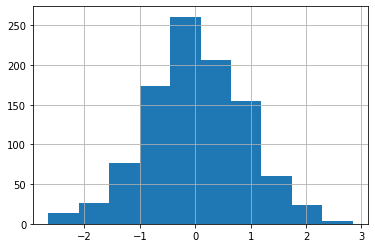

In [8]:
boot_result.t1.hist();

## Bootstrap p-values

In [9]:
lower_tail_f = lambda x: (boot_result.t1.sort_values() <= x).astype(int).mean()
upper_tail_f = lambda x: (boot_result.t1.sort_values() > x).astype(int).mean()
equal_tail_boot_p_value = lambda x: 2* np.min([lower_tail_f(x), upper_tail_f(x)])

## Observable test statistic

In [10]:
train = df.copy()

train_aug = get_augmented_data(df=train,
                               transformation=transformation,
                               frac=pct)
dev_t = transformation(dev)



lr = LRWrapper(hyperparams)
lr.fit(train_aug)


observable = get_disagreement_statistics(df=dev,
                                         df_t=dev_t,
                                         model=lr,
                                         label_translation=label_translation)

observable

,acc,acct,acc_minus_acct,t1,C,D,E,F,t2,pos_trans_rate,neg_trans_rate
0,0.225,0.4,-0.175,-5.749281,41,4,39,116,28.488372,0.906977,0.093023


### 1) Bootstrap hypothesis test 

In [11]:
alpha_t_test = 0.05
print(equal_tail_boot_p_value(observable.t1.values[0]))
print(equal_tail_boot_p_value(observable.t1.values[0]) < alpha_t_test)

0.0
True


### 2) Using bootstrap to correct the choice of alpha 

- Using asymptotic theory to calculate the simulated P-values
- Finding the $\alpha$-quantile of the empirical distribution of the P-values, $\alpha_\rho$
- Performing hypothesis test using  $\alpha_\rho$

#### Checking type I error rate

In [12]:
alpha_t_test = 0.05
rho = pcts[0]
boot_result.loc[:, "p_values"]  = 1 - scipy.stats.chi2.cdf(boot_result.t1 ** 2, df=1)
boot_result.loc[:, "paired_t_test"] = (boot_result.p_values < alpha_t_test).astype(int)
type_I_error_rate = boot_result.paired_t_test.mean()
print("({}): type I error rate = {:.3f} | expected = {:.3f}".format(rho, type_I_error_rate, alpha_t_test))

(0.345): type I error rate = 0.030 | expected = 0.050


#### Plotting P-values frequency

test =  True


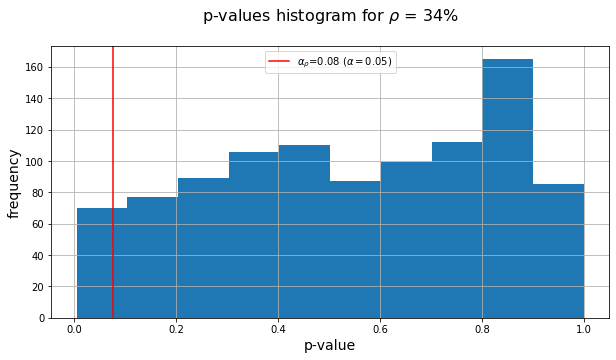

In [13]:
p_values = boot_result.p_values
alpha_rho = np.quantile(p_values.dropna(), alpha_t_test)

# for comparison
# p_values = pd.Series(np.random.uniform(0,1,B))
# alpha_rho = np.quantile(p_values, alpha_t_test)



fig, ax = plt.subplots(figsize=(10,5))
p_values.hist(ax=ax);
plt.axvline(x=alpha_rho, color='r', linestyle='-', label=r"$\alpha_\rho$={:.2f} ($\alpha = {:.2f}$)".format(alpha_rho, alpha_t_test));
ax.set_xlabel("p-value", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title(r"p-values histogram for $\rho$ = {:.0%}".format(rho) +"\n", fontsize=16)
plt.legend(loc="best");

test = (1 - scipy.stats.chi2.cdf(observable.t1 ** 2, df=1)[0]) < alpha_rho

print("test = ", test)

## Finding the $\alpha$-quantile for different $\rho$'s

In [31]:
B = 600
pcts = np.array(range(0,11,))/10
ids = [[i] * B for i in pcts]
ids = reduce(lambda x,y: x + y, ids)

boot_stats = []

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}

for pct in tqdm(ids):
    train_b = get_bootstrap_replications(df)
    dev_b = get_bootstrap_replications(dev)
    train_b_aug = get_augmented_data(df=train_b,
                                     transformation=transformation,
                                     frac=pct)
    dev_b_original, dev_b_t = apply_transformation_under_H0(dev_b, df_transformation_f=transformation)
    
    lr = LRWrapper(hyperparams)
    lr.fit(train_b_aug)

    st = get_disagreement_statistics(df=dev_b_original,
                                     df_t=dev_b_t,
                                     model=lr,
                                     label_translation=label_translation)


    boot_stats.append(st)
    del lr, train_b, dev_b
    

boot_result = pd.concat(boot_stats)
boot_result.index = ids
boot_result.index.name = "pcts"

100%|██████████| 6600/6600 [17:03<00:00,  3.48it/s]


$\rho$,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
$\alpha_\rho$,NaN,0.057151,0.058851,0.076368,0.084814,0.075522,0.094099,0.112229,0.075129,0.099497,0.09461


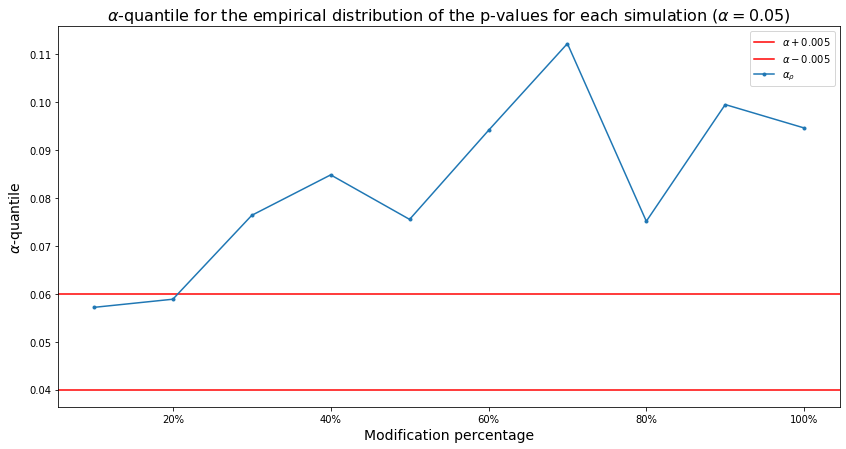

In [36]:
alpha_t_test = 0.05
boot_result.loc[:, "p_values"]  = 1 - scipy.stats.chi2.cdf(boot_result.t1 ** 2, df=1)
alpha_rho = pd.Series([np.quantile(boot_result.loc[rho].p_values, alpha_t_test) for rho in pcts], index=pcts)

# for comparison
# alpha_rho = pd.Series([np.quantile(np.random.uniform(0,1,B), alpha_t_test) for rho in pcts], index=pcts)


alpha_rho.index = alpha_rho.index.map(lambda x: "{:.0%}".format(x))
alpha_rho.index.name = r'$\rho$'

alpha_rho.name = r'$\alpha_\rho$'
display(HTML(alpha_rho.to_frame().transpose().to_html()))


fig, ax = plt.subplots(figsize=(14,7))
plt.axhline(y=alpha_t_test + 0.01, color='r', linestyle='-', label=r"$\alpha + 0.005$")
plt.axhline(y=alpha_t_test - 0.01, color='r', linestyle='-', label=r"$\alpha - 0.005$")
alpha_rho.plot(ax=ax,style='.-');
ax.set_xlabel("Modification percentage", fontsize=14);
ax.set_ylabel(r"$\alpha$-quantile", fontsize=14);
ax.set_title(r"$\alpha$-quantile for the empirical distribution of the p-values for each simulation ($\alpha = {:.2f}$)".format(alpha_t_test), fontsize=16)
plt.legend(loc="best");

,[0.0 - 0.01],[0.01 - 0.02],[0.02 - 0.03],[0.03 - 0.04],[0.04 - 0.05]
count,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.097879,0.103939,0.106515,0.103485,0.099697
std,0.011133,0.011433,0.008513,0.017037,0.011076
min,0.076667,0.088333,0.095000,0.078333,0.080000
25%,0.090000,0.095000,0.100000,0.093333,0.093333
50%,0.100000,0.100000,0.106667,0.103333,0.098333
75%,0.107500,0.114167,0.113333,0.114167,0.107500
max,0.110000,0.120000,0.120000,0.136667,0.116667


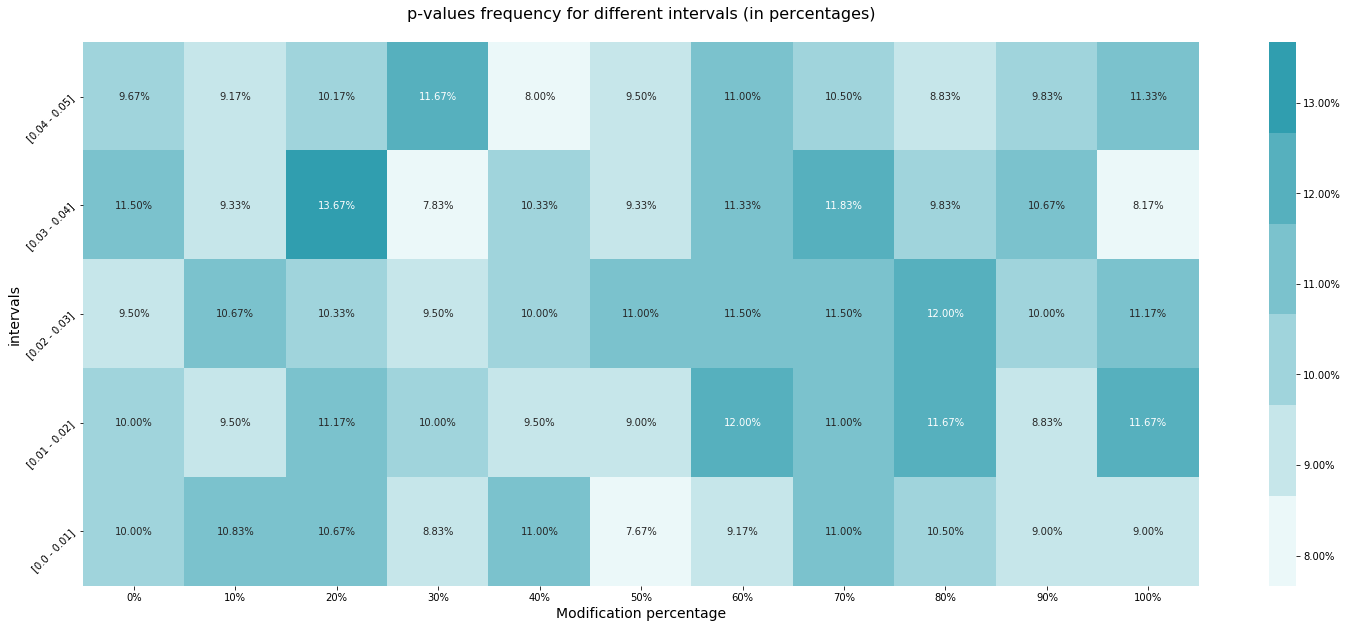

In [46]:
space = np.array(range(0,6))/100
columns = []
p_values_freqs = []


for i,pc in enumerate(space):
    try:
        columns.append("[{} - {}]".format(pc, space[i+1]))
    except IndexError:
        pass

for rho in pcts:
    ps = boot_result.loc[rho].p_values

#     for comparison
#     ps = np.random.uniform(0,1,B*10)
    
    p_values_freq = np.histogram(ps, bins=space)[0] / B
    p_values_freq = pd.DataFrame(p_values_freq).transpose()
    p_values_freq.index = [rho]
    p_values_freq.columns = columns
    p_values_freqs.append(p_values_freq)

freqs = pd.concat(p_values_freqs)
freqs.index = freqs.index.map(lambda x: "{:.0%}".format(x))

display(HTML(freqs.describe().to_html()))


cmap = sns.light_palette((210, 90, 60), input="husl")

fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(freqs[columns[::-1]].transpose(),cmap=cmap, cbar=True, annot=True, fmt='.2%');
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 2))
ax.set_xlabel("Modification percentage", fontsize=14);
ax.set_ylabel(r"intervals", fontsize=14);
ax.set_title("p-values frequency for different intervals (in percentages)\n", fontsize=16)
plt.yticks(rotation=45);
# fig.savefig("t.png")